In [1]:
import os, json

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers
tfs = tf.summary

import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [2]:
class ManifoldEncoder(tfl.Layer):
    
    def __init__(self,
                 latent_dim=64,
                 name="manifold_encoder",
                 **kwargs):
        
        # Initialise superclass
        super(ManifoldEncoder, self).__init__(name=name, **kwargs)
        
        # Set fields
        self.latent_dim = latent_dim
        
        # --------------------------------------------------------------
        # Define layers
        # --------------------------------------------------------------
        
        self.layers = [
            tfl.Reshape((28, 28, 1), input_shape=(28, 28)),
            tfl.Conv2D(filters=64,
                       kernel_size=(5, 5),
                       strides=2,
                       padding="same",
                       name="encoder_conv1"),
            tf.nn.leaky_relu,
            tfl.Conv2D(filters=128,
                       kernel_size=(5, 5),
                       strides=2,
                       padding="same",
                       use_bias=False,
                       name="encoder_conv2"),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Flatten(),
            tfl.Dense(units=1024,
                      use_bias=False,
                      name="encoder_linear1"),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu
        ]
        
        self.loc_head = tfl.Dense(units=self.latent_dim,
                                  name="encoder_loc_head")
        self.log_scale_head = tfl.Dense(units=self.latent_dim,
                                        name="encoder_scale_head")
        
    def call(self, inputs, training=True):
        
        activations = inputs
        
        for layer in self.layers:
            
            if isinstance(layer, tfl.BatchNormalization):
                activations = layer(activations, training=training)
                
            else:
                activations = layer(activations)
            
        loc = self.loc_head(activations)
        scale = tf.nn.softplus(self.log_scale_head(activations))
        
        self.posterior = tfd.Normal(loc=loc, scale=scale)
        
        return self.posterior.sample()
    
    
class ManifoldDecoder(tfl.Layer):
    
    def __init__(self, 
                 name="manifold_decoder",
                 **kwargs):
        
        # Initialise superclass
        super(ManifoldDecoder, self).__init__(name=name, **kwargs)
        
        # Hyperparams
        self.log_gamma = tf.Variable(0., "log_gamma")
        
        # --------------------------------------------------------------
        # Define layers: reverse of a ManifoldEncoder
        # --------------------------------------------------------------
        self.layers = [
            tfl.Dense(units=1024),
            tf.nn.leaky_relu,
            tfl.Dense(units=7 * 7 * 128,
                      use_bias=False),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Reshape((7, 7, 128)),
            tfl.Conv2DTranspose(filters=64,
                                kernel_size=(5, 5),
                                strides=2,
                                padding="same",
                                use_bias=False),
            tfl.BatchNormalization(),
            tf.nn.leaky_relu,
            tfl.Conv2DTranspose(filters=1,
                                kernel_size=(5, 5),
                                padding="same",
                                strides=2)
        ]
        
    def call(self, inputs, training=True):
        
        activations = inputs
        
        for layer in self.layers:
            
            if isinstance(layer, tfl.BatchNormalization):
                activations = layer(activations, training=training)
                
            else:
                activations = layer(activations)
            
            
        likelihood_scale = tf.exp(self.log_gamma)
        self.likelihood = tfd.Normal(loc=activations,
                                     scale=likelihood_scale)
        
        return tf.nn.sigmoid(activations)
    

class ManifoldVAE(tfk.Model):
    
    def __init__(self,
                 latent_dim=64,
                 name="manifold_vae",
                 **kwargs):
        
        super(ManifoldVAE, self).__init__(name=name,
                                          **kwargs)
        
        # Define stuff
        self.latent_dim = latent_dim
        self.prior = tfd.Normal(loc=tf.zeros(latent_dim),
                                scale=tf.ones(latent_dim))
        
        # Define blocks
        self.encoder = ManifoldEncoder(latent_dim=self.latent_dim)
        self.decoder = ManifoldDecoder()
        
    @property 
    def posterior(self):
        return self.encoder.posterior
    
    @property
    def likelihood(self):
        return self.decoder.likelihood
    
    @property
    def log_gamma(self):
        return self.decoder.log_gamma
    
    @property
    def kl_divergence(self):
        return tfd.kl_divergence(self.posterior, self.prior)
    
    @property
    def log_prob(self):
        return tf.reduce_sum(self._log_prob)
         
    def call(self, inputs, training=True):
        
        latents = self.encoder(inputs, training=training)
        reconstruction = self.decoder(latents, training=training)
        
        self._log_prob = self.likelihood.log_prob(inputs[..., tf.newaxis])
        
        return reconstruction
    
    
# ============================================================================
# ============================================================================
# Second VAE
# ============================================================================
# ============================================================================

class MeasureEncoder(tfl.Layer):
    
    def __init__(self,
                 second_stage_depth=4,
                 second_stage_units=1024,
                 latent_dim=64,
                 name="measure_encoder",
                 **kwargs):
        
        # Initialise superclass
        super(MeasureEncoder, self).__init__(name=name, **kwargs)
        
        # Set fields
        self.latent_dim = latent_dim
        self.second_stage_depth = second_stage_depth
        self.second_stage_units = second_stage_units
        
        # --------------------------------------------------------------
        # Define layers
        # --------------------------------------------------------------
        
        self.layers = [tfl.Dense(units=self.second_stage_units) for i in range(self.second_stage_depth)]
        
        self.loc_head = tfl.Dense(units=self.latent_dim,
                                  name="encoder_loc_head")
        self.log_scale_head = tfl.Dense(units=self.latent_dim,
                                        name="encoder_scale_head")
        
    def call(self, inputs):
        
        activations = inputs
        
        for layer in self.layers:
            
            activations = tf.nn.relu(layer(activations))
            
        # Add residual connection
        activations = tf.concat([activations, inputs], axis=-1)
            
        loc = self.loc_head(activations)
        scale = tf.exp(self.log_scale_head(activations))
        
        self.posterior = tfd.Normal(loc=loc, scale=scale)
        
        return self.posterior.sample()
    
    
class MeasureDecoder(tfl.Layer):
    
    def __init__(self, 
                 latent_dim=64,
                 second_stage_units=1024,
                 second_stage_depth=4,
                 name="measure_decoder",
                 **kwargs):
        
        # Initialise superclass
        super(MeasureDecoder, self).__init__(name=name, **kwargs)
        
        self.latent_dim = latent_dim
        self.second_stage_depth = second_stage_depth
        self.second_stage_units = second_stage_units
        
        # Hyperparams
        self.log_gamma = tf.Variable(0., "log_gamma")
        
        # --------------------------------------------------------------
        # Define layers: reverse of a MeasureEncoder
        # --------------------------------------------------------------
        self.layers = [tfl.Dense(units=self.second_stage_units) for i in range(self.second_stage_depth - 1)]
        self.latent_head = tfl.Dense(units=self.latent_dim)
        
        
    def call(self, inputs):
        
        activations = inputs
        
        for layer in self.layers:
            
            activations = tf.nn.relu(layer(activations))
            
        # Add residual connection
        activations = tf.concat([activations, inputs], axis=-1)
        activations = self.latent_head(activations)
            
        likelihood_scale = tf.exp(self.log_gamma)
        self.likelihood = tfd.Normal(loc=activations,
                                     scale=likelihood_scale)
        
        return activations
    

class MeasureVAE(tfk.Model):
    
    def __init__(self,
                 latent_dim=64,
                 second_stage_depth=4,
                 name="measure_vae",
                 **kwargs):
        
        super(MeasureVAE, self).__init__(name=name,
                                          **kwargs)
        
        # Define stuff
        self.latent_dim = latent_dim
        self.prior = tfd.Normal(loc=tf.zeros(latent_dim),
                                scale=tf.ones(latent_dim))
        
        # Define blocks
        self.encoder = MeasureEncoder(latent_dim=self.latent_dim, second_stage_depth=second_stage_depth)
        self.decoder = MeasureDecoder(second_stage_depth=second_stage_depth)
        
    @property 
    def posterior(self):
        return self.encoder.posterior
    
    @property
    def likelihood(self):
        return self.decoder.likelihood
    
    @property
    def log_gamma(self):
        return self.decoder.log_gamma
    
    @property
    def kl_divergence(self):
        return tfd.kl_divergence(self.posterior, self.prior)
    
    @property
    def log_prob(self):
        return tf.reduce_sum(self._log_prob)
         
    def call(self, inputs, training=True):
        
        latents = self.encoder(inputs)
        reconstruction = self.decoder(latents)
        
        self._log_prob = self.likelihood.log_prob(inputs)
        
        return reconstruction

In [3]:
def mnist_input_fn(data, batch_size=256, shuffle_samples=5000):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(shuffle_samples)
    dataset = dataset.map(mnist_parse_fn)
    dataset = dataset.batch(batch_size)

    return dataset


def mnist_parse_fn(data):
    return tf.cast(data, tf.float32) / 255.


optimizers = {
    "sgd": tfk.optimizers.SGD,
    "adam": tfk.optimizers.Adam,
}

In [12]:
MODEL_DIR = "/tmp/2-stage-vae-v3/"

config = {
        "num_training_examples": 60000,
        "batch_size": 250,
        "num_epochs": 20,
        "num_epochs_stage_2": 100,
        
        "beta1": 0.1,
        "beta2": 1.,
        "warmup": 10.,
        
        "learning_rate": 1e-3,
        
        "optimizer": "adam",
        
        "checkpoint_name": "_ckpt",
        "log_freq": 100,
    }

In [25]:
num_batches = config["num_training_examples"] // config["batch_size"] + 1


print("Configuration:")
print(json.dumps(config, indent=4, sort_keys=True))

# ==========================================================================
# Load dataset
# ==========================================================================

((train_data, _),
 (eval_data, _)) = tf.keras.datasets.mnist.load_data()

# ==========================================================================
# Create model
# ==========================================================================

manifold_vae = ManifoldVAE(latent_dim=64)
measure_vae = MeasureVAE(latent_dim=64)

manifold_optimizer = optimizers[config["optimizer"]](config["learning_rate"])
measure_optimizer = optimizers[config["optimizer"]](config["learning_rate"])

# ==========================================================================
# Checkpoints
# ==========================================================================

# Create checkpoint and its manager
manifold_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=manifold_optimizer, net=manifold_vae)
manifold_manager = tf.train.CheckpointManager(manifold_ckpt, MODEL_DIR + "/manifold_checkpoints", max_to_keep=3)

measure_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=measure_optimizer, net=measure_vae)
measure_manager = tf.train.CheckpointManager(measure_ckpt, MODEL_DIR + "/measure_checkpoints", max_to_keep=3)

# Attempt to restore model
manifold_ckpt.restore(manifold_manager.latest_checkpoint)
if manifold_manager.latest_checkpoint:
    print("Restored from {}".format(manifold_manager.latest_checkpoint))
else:
    print("Initializing manifold VAE from scratch.")
    
# Attempt to restore model
measure_ckpt.restore(measure_manager.latest_checkpoint)
if measure_manager.latest_checkpoint:
    print("Restored from {}".format(measure_manager.latest_checkpoint))
else:
    print("Initializing Measure VAE from scratch.")
# ==========================================================================
# Train the model
# ==========================================================================

def train_first_stage(log_freq=10, save_freq=50):
    
    beta = config["beta1"]

    for epoch in range(1, config["num_epochs"] + 1):

        dataset = mnist_input_fn(data=train_data,
                                batch_size=config["batch_size"])

        with tqdm(total=num_batches) as pbar:
            for batch in dataset:
                
                # Increment checkpoints step
                manifold_ckpt.step.assign_add(1)

                with tf.GradientTape() as tape:

                    output = manifold_vae(batch, training=True)

                    kl = manifold_vae.kl_divergence
                    total_kl = tf.reduce_sum(kl)

                    log_prob = manifold_vae.log_prob

                    warmup_coef = 1. #tf.minimum(1., manifold_optimizer.iterations.numpy() / (config["warmup"] * num_batches))

                    # negative ELBO
                    loss = total_kl - beta * warmup_coef * log_prob 

                    output = tf.cast(output, tf.float32)

                gradients = tape.gradient(loss, manifold_vae.trainable_variables)
                manifold_optimizer.apply_gradients(zip(gradients, manifold_vae.trainable_variables))
                
                # Log stuff
                if tf.equal(manifold_optimizer.iterations % log_freq, 0):
                    # Add tensorboard summaries
                    tfs.scalar("Loss", loss, step=manifold_optimizer.iterations)
                    tfs.scalar("Total_KL", total_kl, step=manifold_optimizer.iterations)
                    tfs.scalar("Max_KL", tf.reduce_max(kl), step=manifold_optimizer.iterations)
                    tfs.scalar("Log-Probability", log_prob, step=manifold_optimizer.iterations)
                    tfs.scalar("Warmup_Coef", warmup_coef, step=manifold_optimizer.iterations)
                    tfs.scalar("Gamma-x", tf.exp(manifold_vae.log_gamma), step=manifold_optimizer.iterations)
                    tfs.image("Reconstruction", output, step=manifold_optimizer.iterations)
                    
                if tf.equal(manifold_ckpt.step % save_freq, 0):
                    manifold_manager.save()

                # Update the progress bar
                pbar.update(1)
                pbar.set_description("Epoch {}, ELBO: {:.2f}".format(epoch, loss))

    print("First Stage Training Complete!")
                
def train_second_stage(log_freq=10, save_freq=50):
    
    beta = config["beta2"]

    for epoch in range(1, config["num_epochs_stage_2"] + 1):

        dataset = mnist_input_fn(data=train_data,
                                batch_size=config["batch_size"])

        with tqdm(total=num_batches) as pbar:
            for batch in dataset:
                
                # Increment checkpoints step
                measure_ckpt.step.assign_add(1)

                with tf.GradientTape() as tape:
                    
                    latents = manifold_vae.encoder(batch, training=False)

                    output = measure_vae(latents)

                    kl = measure_vae.kl_divergence
                    total_kl = tf.reduce_sum(kl)

                    log_prob = measure_vae.log_prob

                    warmup_coef = 1. #tf.minimum(1., measure_optimizer.iterations.numpy() / (config["warmup"] * num_batches))

                    # negative ELBO
                    loss = total_kl - beta * warmup_coef * log_prob 

                    output = tf.cast(output, tf.float32)

                gradients = tape.gradient(loss, measure_vae.trainable_variables)
                measure_optimizer.apply_gradients(zip(gradients, measure_vae.trainable_variables))
                
                # Log stuff
                if tf.equal(measure_optimizer.iterations % log_freq, 0):
                    # Add tensorboard summaries
                    tfs.scalar("2-Loss", loss, step=measure_optimizer.iterations)
                    tfs.scalar("2-Total_KL", total_kl, step=measure_optimizer.iterations)
                    tfs.scalar("2-Max_KL", tf.reduce_max(kl), step=measure_optimizer.iterations)
                    tfs.scalar("2-Log-Probability", log_prob, step=measure_optimizer.iterations)
                    tfs.scalar("2-Warmup_Coef", warmup_coef, step=measure_optimizer.iterations)
                    tfs.scalar("2-Gamma-z", tf.exp(measure_vae.log_gamma), step=measure_optimizer.iterations)
                    
                if tf.equal(measure_ckpt.step % save_freq, 0):
                    measure_manager.save()

                # Update the progress bar
                pbar.update(1)
                pbar.set_description("Epoch {}, ELBO: {:.2f}".format(epoch, loss))
                
    print("Second Stage Training Complete!")
                
train_summary_writer = tfs.create_file_writer(MODEL_DIR + '/summaries/train')            

with train_summary_writer.as_default():
    #train_first_stage(log_freq=10)
    
    manifold_vae.trainable = False
    
    train_second_stage(log_freq=10)

Configuration:
{
    "batch_size": 250,
    "beta1": 0.1,
    "beta2": 1.0,
    "checkpoint_name": "_ckpt",
    "learning_rate": 0.001,
    "log_freq": 100,
    "num_epochs": 20,
    "num_epochs_stage_2": 100,
    "num_training_examples": 60000,
    "optimizer": "adam",
    "warmup": 10.0
}


W0708 21:16:27.988155 139747660531456 util.py:244] Unresolved object in checkpoint: (root).optimizer.iter
W0708 21:16:27.988668 139747660531456 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_1
W0708 21:16:27.990243 139747660531456 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_2
W0708 21:16:27.990781 139747660531456 util.py:244] Unresolved object in checkpoint: (root).optimizer.decay
W0708 21:16:27.991265 139747660531456 util.py:244] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0708 21:16:27.991772 139747660531456 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#

Restored from /tmp/2-stage-vae-v3//manifold_checkpoints/ckpt-96
Restored from /tmp/2-stage-vae-v3//measure_checkpoints/ckpt-456



Second Stage Training Complete!


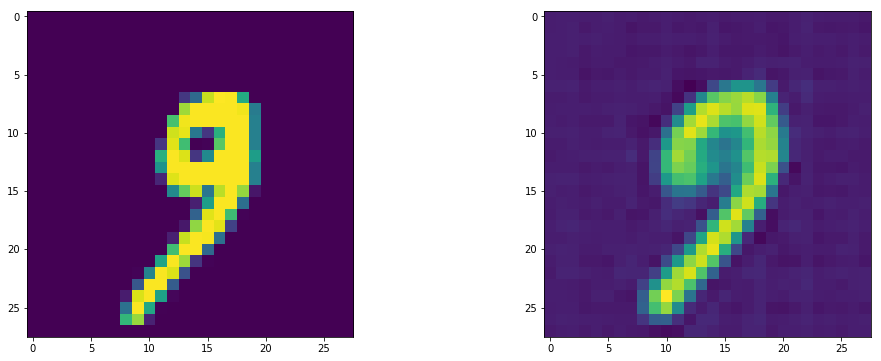

In [41]:
idx = 1000

im = eval_data[idx:idx + 1]
z_1 = manifold_vae.encoder(mnist_parse_fn(im), training=False)
z_2 = measure_vae.encoder(z_1)
#z_2 = measure_vae.posterior.sample()
# z = tf.ones((1, 64))
#z = vae.posterior.sample()
z = measure_vae.decoder(z_2)
#print(z_2)
#print(z_1)
#print(z)
rec_im = manifold_vae.decoder(z, training=False)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.imshow(im[0])

plt.subplot(122)
plt.imshow(tf.squeeze(rec_im))

plt.show()

<tf.Tensor: id=4771998, shape=(), dtype=float32, numpy=0.10662687>